#  뉴스기사 요약해보기

## Step 1. 데이터 수집하기

In [34]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [36]:
data.sample(10)

,headlines,text
33379,Library evacuated as rotting fruit sparks fear...,Nearly 600 people were evacuated from a librar...
39911,Trump probably has power to pardon himself: US...,US President Donald Trump's lawyer Rudy Giulia...
81337,China's 3rd richest man to sell firm's hotels ...,"Dalian Wanda, founded by China's third richest..."
86856,"US has turned into a tragic, dumbass comedy: R...",During a commencement ceremony speech at Brown...
12256,Sonia's monthly pay at Paytm went from Ã¢ÂÂ¹1...,Family of Sonia Dhawan who was arrested for al...
26245,Broadcom loses $16 bn in m-cap after CA Techno...,Chipmaker Broadcom lost nearly $16 billion in ...
32550,Sweden makes sex education films for migrants,Sweden has made a series of films on sex educa...
56859,IndoStar Capital to provide Vehicle & Affordab...,"IndoStar Capital Finance Ltd, one of India's m..."
42150,AAP to contest Haryana Assembly polls in 2019,Addressing a rally in Haryana's Hisar on Sunda...
37626,"Golf star hits moving ball towards hole, penal...",Five-time major championship-winning golfer US...


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


## Step 2. 데이터 전처리하기 (추상적 요약)
>실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.<br>
만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [39]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


* text가 달라도 headlines는  동일할 수 있음. 하지만 text  자체가 중복이 된 경우는 중복 샘플이므로 제거해야됨.

In [40]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [41]:
# Null 값이 있는지 확인
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


### 텍스트 정규화와 불용어 제거

단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있음.<br>
예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현, 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있음.

이러한 방법론을 텍스트 처리에서는 **텍스트 정규화(text normalization)** 라고 함.

In [42]:
# 정규화를 위한 사전(dictionary) 구성 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재 이를 **불용어(stopwords)**라고 부름.<br>
때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [43]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있음.<br>
이를 사용하여 **불용어를 제거** 외에도 모든 **영어 문자는 소문자로**, 섞여있는 **html 태그를 제거**, 정규 표현식을 통해 **각종 특수문자를 제거**로 정말 필요한 내용만 잘 학습할 수 있도록 처리

In [44]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

함수의 하단 **NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출**하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정.<br>
Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 **불용어들이 headlines에는 남아 있는 게 더 좋을 것 같음**. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가.

In [45]:
# 간단한 예제 생성하여 전처리 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'

print("text: ", preprocess_sentence(temp_text))

text:  everything bought great infact ordered twice third ordered wasfor mother father


In [46]:
# 먼저 전체 Text를 전처리
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [48]:
# 전체 headlines 데이터에 대한 전처리 - 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False 넣어줌
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


**텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋음.**<br>
정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있음.<br>
쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장하고 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체

In [50]:
# 전처리 데이터 데이터프레임에 재저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [54]:
# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인
print(data.isnull().sum())
print('전체 샘플수 :', (len(data)))

text         0
headlines    0
dtype: int64
전체 샘플수 : 98360


### 훈련데이터와 테스트데이트 나누기

#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


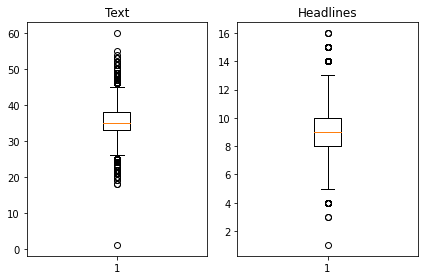

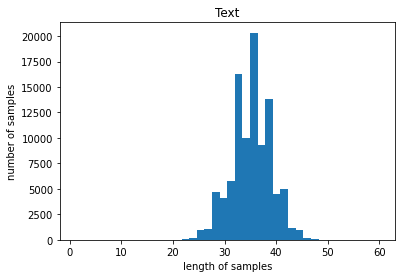

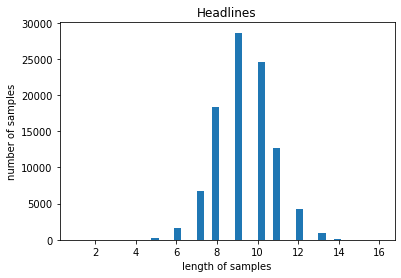

In [56]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 텍스트의 최소 길이가 1  최대 길이가 60  평균 길이는 35로 그래프로 봤을 때 대체적으로는 45 이하의 길이를 가지는 것으로 보임.
* 헤드라인의 최소 길이가 1  최대 길이 16  평균 길이는 9로 그래프 상 대체적으로 12 이하의 길이를 가지는 것으로 보임

In [57]:
# Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정함.
text_max_len = 45
headlines_max_len = 12

In [58]:
# 임의의 길이를 선택했을때 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 확인하는 통계함수 만들기
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [59]:
# 통계함수 적용
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [60]:
# 정해진 길이보다 길면 데어터 제외되도록
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


#### 시작 토큰과 종료 토큰 추가하기

In [61]:
# 요약 데이터(headlines)에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [62]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 훈련 데이터와 테스트 데이터 분리

In [63]:
#  encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[44803 63562 40403 ... 46404 21038 77718]


In [64]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의 -  잘 섞인 샘플이 됨.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [65]:
# 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리 예정

# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [66]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

* 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 함.
* 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현.

In [67]:
# Keras의 토크나이저를 사용 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

* 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여 됨.
* 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장. - 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행 하려함.
* src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장 되어 있음.

In [68]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68990
등장 빈도가 6번 이하인 희귀 단어의 수: 47055
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21935
단어 집합에서 희귀 단어의 비율: 68.2055370343528
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.531037375852337


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 68% 이상을 차지.<br>
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.53%<br>
그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 함.

In [69]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [70]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[131, 1, 888, 1479, 1770, 7400, 6, 2729, 6127, 2325, 5894, 427, 619, 5777, 348, 109, 131, 2769, 2716, 1212, 97, 453, 362, 619, 771, 3159, 1770, 2334, 2799], [624, 172, 1753, 605, 2575, 246, 6816, 172, 455, 2654, 1753, 146, 1, 17, 1297, 2915, 6421, 601, 1916, 1753], [164, 2106, 75, 429, 429, 2473, 2561, 40, 1975, 1180, 2047, 734, 542, 206, 200, 421, 10, 1328, 1180, 2047, 484, 569, 484, 1851, 44, 444, 1]]


* 현재 단어 집합의 크기를 8,000으로 제한, 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [71]:
# 요약 데이터(headlines)에 대해서도 동일한 작업 수행 
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) # 각 단어에 고유한 정수가 부여

In [72]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29962
등장 빈도가 5번 이하인 희귀 단어의 수: 19627
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10335
단어 집합에서 희귀 단어의 비율: 65.50630799012082
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.733497698758198


In [73]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 158, 1529, 6], [1, 6, 98, 641, 1257, 6, 915], [1, 1233, 968, 1578, 615, 854, 190, 5, 193], [1, 268, 1066, 146, 220, 1935, 9, 1935], [1, 340, 237, 100]]
target
decoder  [[158, 1529, 6, 2], [6, 98, 641, 1257, 6, 915, 2], [1233, 968, 1578, 615, 854, 190, 5, 193, 2], [268, 1066, 146, 220, 1935, 9, 1935, 2], [340, 237, 100, 2]]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있음. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높음.<br>
* 요약문에서 길이가 0이 된 샘플들의 인덱스를 확인 - 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다는것. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나옴 (길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아있음)

In [74]:
#  훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장 후 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 13
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77484
훈련 레이블의 개수 : 77484
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


### 패딩하기
* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰 줌

In [75]:
# 정해두었던 최대 길이로 패딩 - 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤.
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
>일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.<br>
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [80]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [81]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [82]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 모델 훈련하기

In [83]:
# EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할
# val_loss(검증 데이터의 손실)을 관찰 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 195s 613ms/step - loss: 3.8783 - val_loss: 3.5772
Epoch 2/50
303/303 [==============================] - 182s 600ms/step - loss: 3.3981 - val_loss: 3.2329
Epoch 3/50
303/303 [==============================] - 188s 621ms/step - loss: 3.1285 - val_loss: 3.0163
Epoch 4/50
303/303 [==============================] - 189s 624ms/step - loss: 2.9374 - val_loss: 2.8742
Epoch 5/50
303/303 [==============================] - 181s 597ms/step - loss: 2.7997 - val_loss: 2.7762
Epoch 6/50
303/303 [==============================] - 181s 599ms/step - loss: 2.6900 - val_loss: 2.7069
Epoch 7/50
303/303 [==============================] - 178s 588ms/step - loss: 2.6003 - val_loss: 2.6369
Epoch 8/50
303/303 [==============================] - 179s 590ms/step - loss: 2.5231 - val_loss: 2.5929
Epoch 9/50
303/303 [==============================] - 178s 588ms/step - loss: 2.4542 - val_loss: 2.5514
Epoch 10/50
303/303 [==============================] - 178s 588m

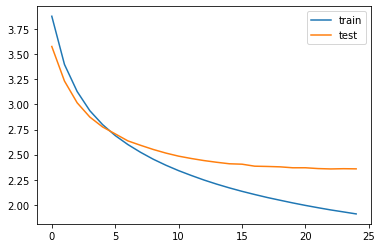

In [84]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
>원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### 인퍼런스 모델 구현하기

In [85]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 함

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [86]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [87]:
# 어텐션 메커니즘을 사용하는 출력층

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [91]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트
* 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인<br>
* Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록

In [92]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [93]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : according reports khilji played ranveer singh upcoming film padmavati portrayed film reportedly relationship khilji general malik played jim khilji rajput queen padmavati played deepika padukone major plot film 
실제 요약 : ranveer in padmavati as report 
예측 요약 :  ranveer deepika to report


원문 : hackers behind global wannacry ransomware attack hit countries since friday earned lakh far enterprises london based company tracks illicit use bitcoin tracked current balance three bitcoin addresses known associated wannacry malware locked users computers demanded ransom bitcoin 
실제 요약 : hackers have lakh so 
예측 요약 :  hackers attack world bank attacks in


원문 : atm industry said recent regulatory changes making operate atms may lead closure half machines march majority atms shut non urban areas added india lakh atms september end 
실제 요약 : new rules may force of in india to close industry body 
예측 요약 :  no plans to increase in indonesia


원문 : nasa rover landed mars found organic molecules co

## Step 5. Summa을 이용해서 추출적 요약해보기
>추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요.<br>
반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

* Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### 데이터 다운로드

In [117]:
import requests
from summa.summarizer import summarize

In [120]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
text_1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### summarize 사용하기

Summa의 summarize()의 인자로 사용되는 값

>text (str) : 요약할 테스트.<br>
>ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
>words (int or None, optional) – 출력에 포함할 단어 수.<br>
>만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.<br>
>split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행 - 원문을 바로 입력으로 넣을 수 있음.

#### 명예의 전당 유현지님 코딩 참조 했음

In [133]:
# 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄임. 원문의 0.5%만을 출력하도록 설정
for i in range(3):
    print("원문 :", text_1['text'][i])
    print("-----------------------------------------------------------------------------------------------------")
    print("실제 요약 :", text_1['headlines'][i])
    print("----------------------------------------------------------------------------------------------------")
    print("추출적 요약 :", summarize(text_1["text"][i], ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
-----------------------------------------------------------------------------------------------------
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
----------------------------------------------------------------------------------------------------
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used 

In [134]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로
for i in range(3):
    print("원문 :", text_1['text'][i])
    print("----------------------------------------------------------------------------------------------------")
    print("실제 요약 :", text_1['headlines'][i])
    print("----------------------------------------------------------------------------------------------------")
    print("추출적 요약 :", summarize(text_1["text"][i], ratio=0.5, split=True))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
----------------------------------------------------------------------------------------------------
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
----------------------------------------------------------------------------------------------------
추출적 요약 : ["upGrad's Online Power Learning has powered 3 lakh+ careers."]


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be us

In [135]:
# 단어의 수로 요약문의 크기를 조절 - 단어를 30개만 선택
for i in range(3):
    print("원문 :", text_1['text'][i])
    print("----------------------------------------------------------------------------------------------------")
    print("실제 요약 :", text_1['headlines'][i])
    print("----------------------------------------------------------------------------------------------------")
    print("추출적 요약 :", summarize(text_1["text"][i], words=30))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
----------------------------------------------------------------------------------------------------
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
----------------------------------------------------------------------------------------------------
추출적 요약 : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a 

## 후기

* 추상적 요약 결과 - 실제요약과 예측요약이 비슷한 단어들로 이루어진 경우도 있고 완전 다른 단어로 요약된 경우들도 보임. 예측요약은 문장으로 보기에는 많이 부족함.

* 추출적 요약 결과 - 기존 문장에서 문장을 꺼내오는 방식 때문인지 추상적 요약보다는 문장으로 완성되어지는 것 처럼 보임.

* summarize 사용시 데이터프레임에서 'test'열만 txt 파일로 저장해서 사용하고 싶었으나 생각처럼 조절되지 않았음. ㅠㅠ
* 모델 훈련 시간이 너무 오래 걸려서 힘들었음.